In [1]:
# Show trade off of transmissibility and escape depending on fraction with immunity and susceptibility
# Need to be clear about which is winning

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

In [3]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils

In [4]:
FIG_PATH = "../manuscript/figures/"

In [5]:
WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Transmissibility variant", "Escape variant"
COLOR_MAP = {WT_LABEL: WT_COLOR, VART_LABEL: VART_COLOR, VARE_LABEL: VARE_COLOR}

In [6]:
# Getting base parameters
R0 = 2.8
gamma = 1 / 3.2
beta = R0 * gamma

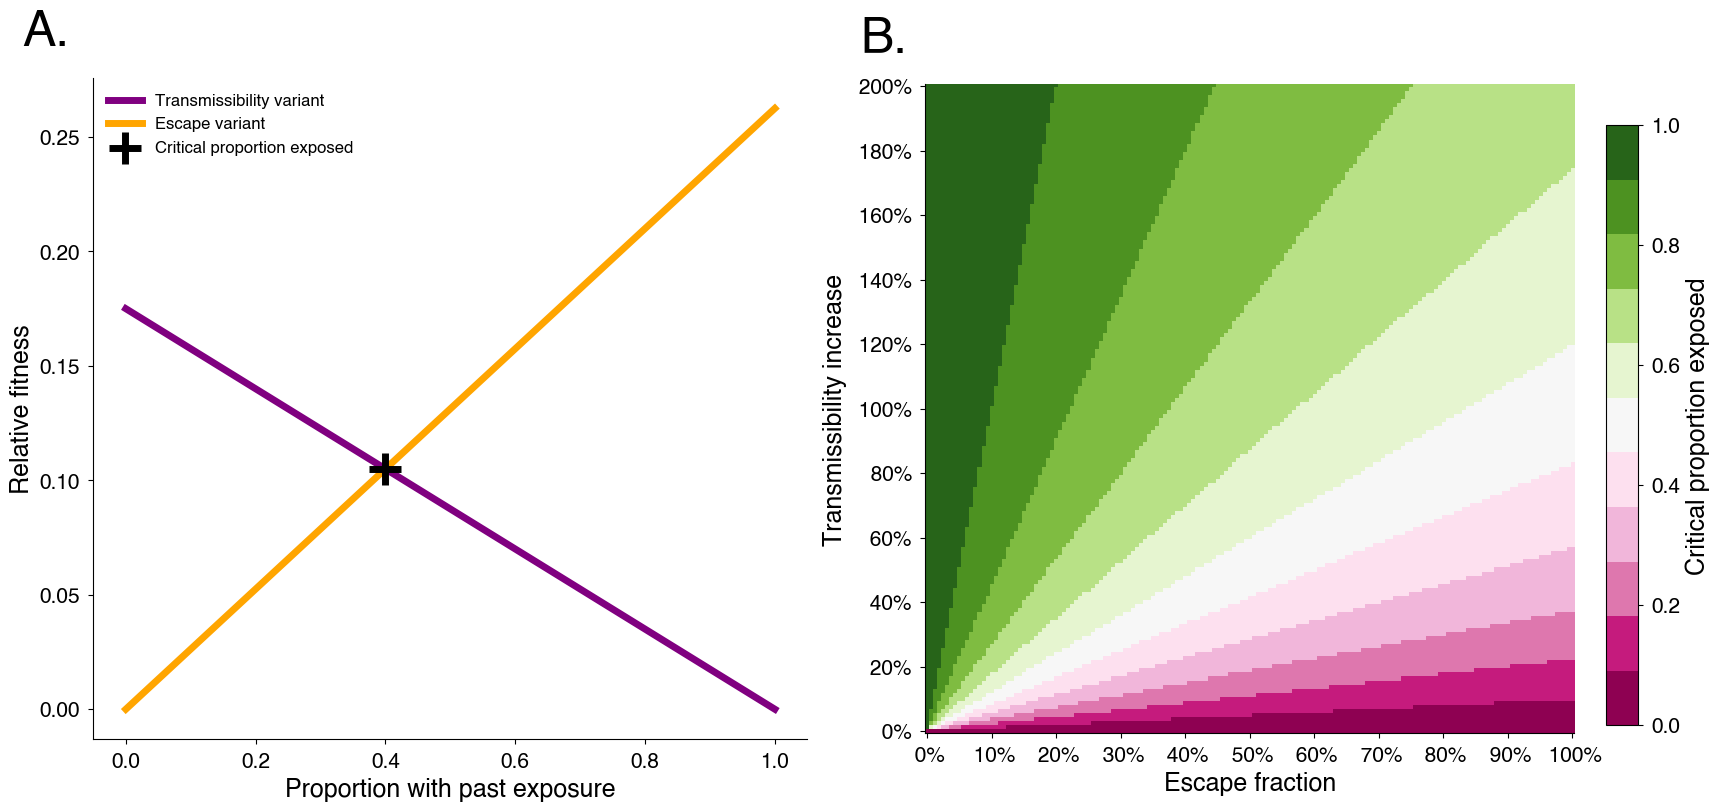

In [7]:
# Set up axes
fig = plt.figure(figsize=(16., 8.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1.1, 1.0])

# A. Proportion vaccinated on x-axis, relative fitness at y.
# Show when immune escape is preferred

### Panel A parameters
eta_E = 0.3
eta_T = 1.2
prop_exposed = np.linspace(0,1,31)
###

ax = fig.add_subplot(spec[0])
var_t_lambda = (eta_T - 1) * beta * (1 - prop_exposed)
var_e_lambda = eta_E * beta * prop_exposed
ax.plot(prop_exposed, var_t_lambda, color = VART_COLOR, label = VART_LABEL)
ax.plot(prop_exposed, var_e_lambda, color = VARE_COLOR, label = VARE_LABEL)
ax.set_xlabel("Proportion with past exposure")
ax.set_ylabel("Relative fitness")

# Highlight point of intersection
def critical_proportion(eta_T, eta_E):
    return (eta_T - 1) / (eta_E + eta_T-1)

crit_prop = critical_proportion(eta_T, eta_E)
crit_relfit = eta_E * beta * crit_prop
ax.scatter(crit_prop, crit_relfit , s=500, color="k", marker="+", zorder=3, label="Critical proportion exposed")
ax.legend(frameon=False)

ax_panel_a = ax

# B. Point of vaccination where escape preferred various eta_E and eta_T
ax = fig.add_subplot(spec[:, 1])

eta_T = np.linspace(3.00, 1.0, 161)
eta_E = np.linspace(0.001, 0.996, 161)

eta_Emg, eta_Tmg = np.meshgrid(eta_E, eta_T)

crit_props = critical_proportion(eta_Tmg, eta_Emg)
cmap = plt.get_cmap('PiYG',11)
im = ax.imshow(crit_props, vmin=0, vmax=1, cmap=cmap)
cbar_ax = fig.add_axes([1.0, 0.1, 0.02, 0.75])
fig.colorbar(im, cbar_ax, label = "Critical proportion exposed")
yticks = [*range(len(eta_T))][::16]
xticks = [*range(len(eta_E))][::16]

ax.set_xticks(xticks)
ax.set_yticks(yticks)

ax.set_xticklabels([f"{eta_E[v]: .2f}" for v in xticks])
ax.set_yticklabels([f"{eta_T[v]: .2f}" for v in yticks])

ax.set_xticklabels([f"{eta_E[v]: .0%}" for v in xticks])
ax.set_yticklabels([f"{(eta_T[v] -1): .0%}" for v in yticks])

ax.set_ylabel("Transmissibility increase")
ax.set_xlabel("Escape fraction")
ax_panel_b = ax


# Add panel labels
import string
axes = [ax_panel_a, ax_panel_b]
ax_labels = string.ascii_uppercase 

for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.05, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')

fig_te_tradeoff = fig
#fig_te_tradeoff.savefig(FIG_PATH + "transmission_tradeoff.png", bbox_inches='tight')

In [8]:
from jax import jit
import jax.numpy as jnp
from jax.experimental.ode import odeint

@jit
def SIR_model(u, t, θ):
    # Susceptible, Infectious wild type, Infectious variant, Recovered wild type, Recovered variant
    S, I, R, Inc = (
        u[0],
        u[1],
        u[2],
        u[3],
    )

    # Transmissibility, recovery rate
    # eta_T is added variant transmissibility in susceptibles,
    # eta_E is escape in recovered wt hosts
    # eta_gam is the ratio between recovery rates
    beta, gam = (θ[0], θ[1])

    lam = beta * S * I 
    recov = gam * I

    # Defining differential equations
    dS = -lam
    dI = lam - recov
    dR = recov

    # New compartments for capturing cummulative incidence
    dIncidence = lam

    return jnp.stack(
        [dS, dI, dR, dIncidence]
    )

def compute_final_epidemic_size(R0, gen=None, u0=None, tmax=None):
    if gen is None:
        gen = 1.0 # Average length of infection (days): 1 / gam_wt
    if u0 is None:
        u0 =  jnp.array([0.999, 0.0001, 0.0, 0.0])
    if tmax is None:
        tmax = 100
    t = jnp.arange(float(tmax))

    # Defining parameters
    gam = 1 / gen
    beta = R0 * gam
    theta = (beta, gam)

    # Running ODE
    Y = odeint(SIR_model, u0, t, theta)
    return Y, Y[-1, 2] # Return states and final recovered population

Y, final_size = compute_final_epidemic_size(R0)

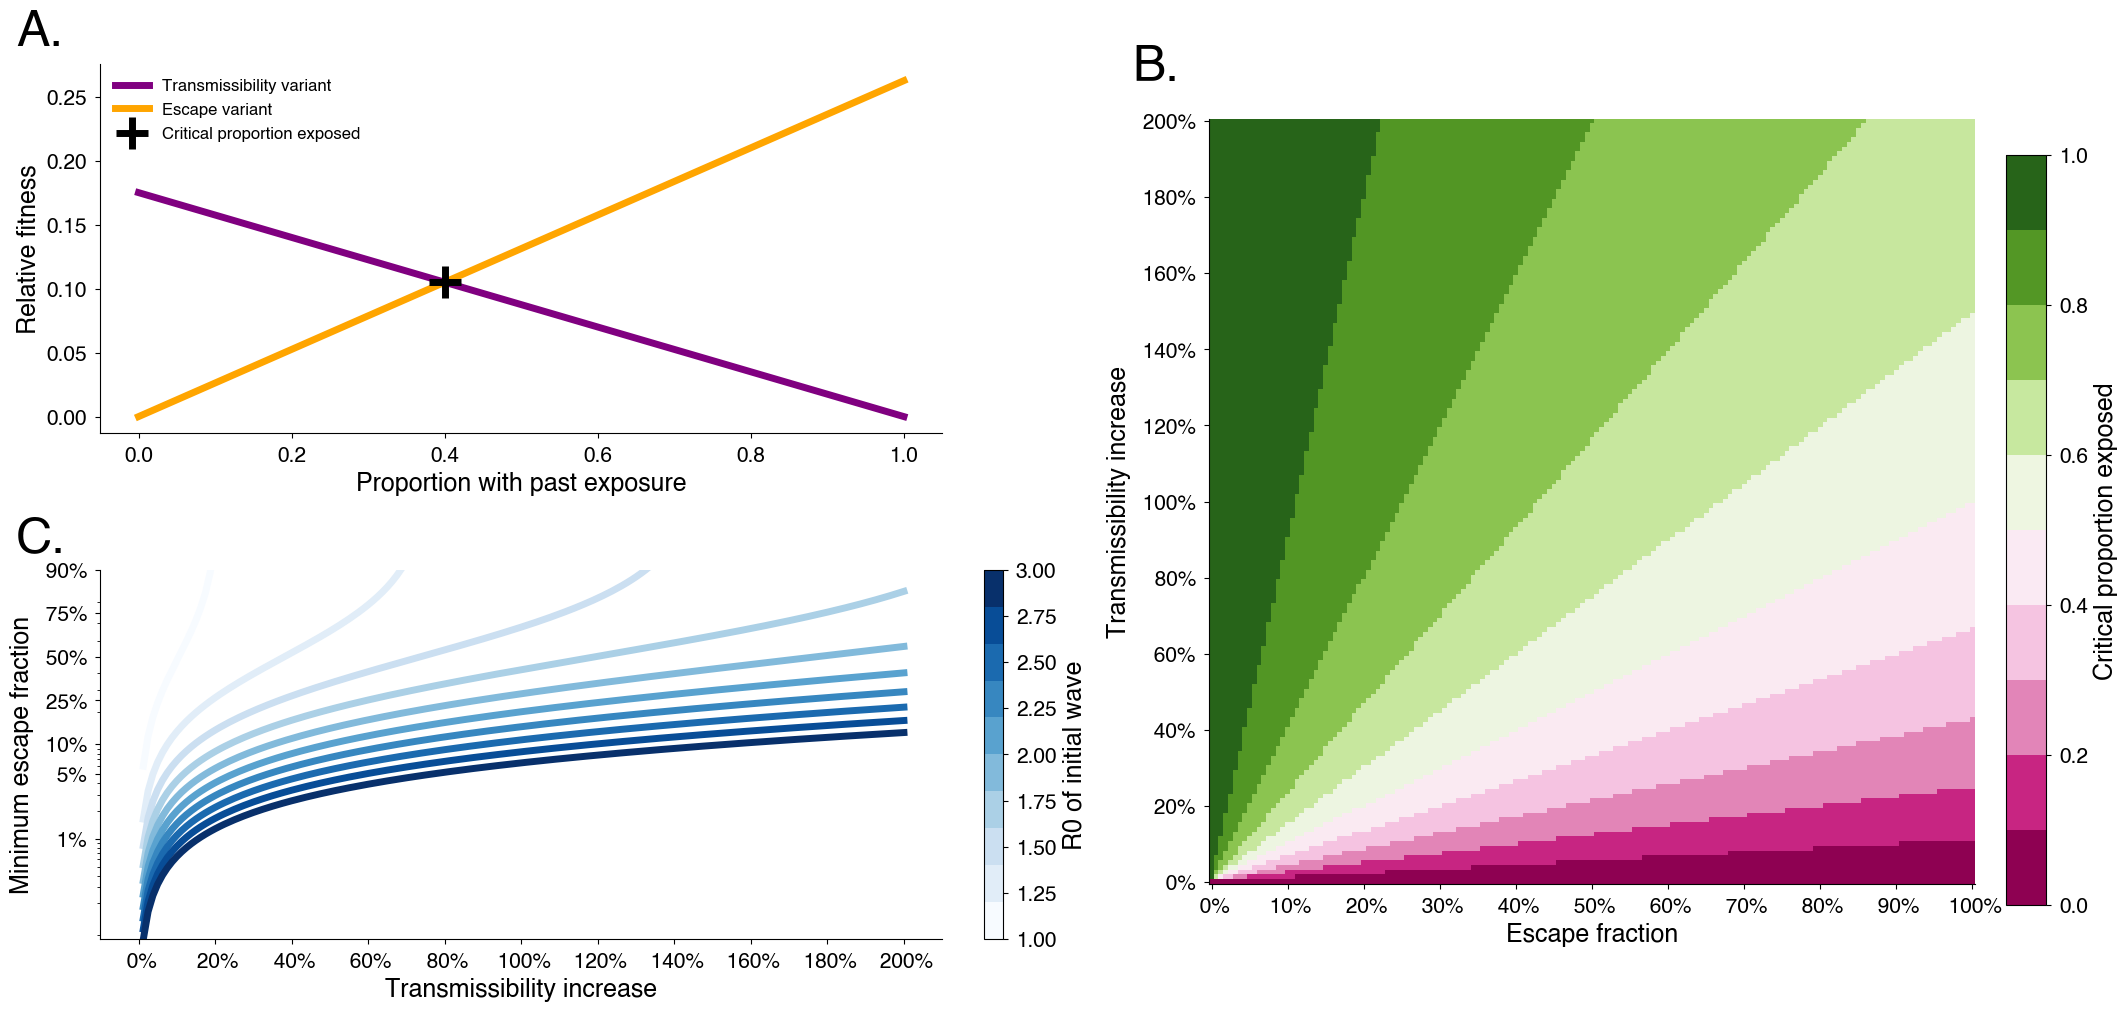

In [10]:
# Set up axes
fig = plt.figure(figsize=(20., 10.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.1, 1.0])

# A. Proportion vaccinated on x-axis, relative fitness at y.
# Show when immune escape is preferred

### Panel A parameters
eta_E = 0.3
eta_T = 1.2
prop_exposed = np.linspace(0,1,31)
###

ax = fig.add_subplot(spec[0])
var_t_lambda = (eta_T - 1) * beta * (1 - prop_exposed)
var_e_lambda = eta_E * beta * prop_exposed
ax.plot(prop_exposed, var_t_lambda, color = VART_COLOR, label = VART_LABEL)
ax.plot(prop_exposed, var_e_lambda, color = VARE_COLOR, label = VARE_LABEL)
ax.set_xlabel("Proportion with past exposure")
ax.set_ylabel("Relative fitness")

# Highlight point of intersection
def critical_proportion(eta_T, eta_E):
    return (eta_T - 1) / (eta_E + eta_T-1)

crit_prop = critical_proportion(eta_T, eta_E)
crit_relfit = eta_E * beta * crit_prop
ax.scatter(crit_prop, crit_relfit , s=500, color="k", marker="+", zorder=3, label="Critical proportion exposed")
ax.legend(frameon=False)

ax_panel_a = ax

# B. Point of vaccination where escape preferred various eta_E and eta_T
ax = fig.add_subplot(spec[:, 1])

eta_T = np.linspace(3.00, 1.0, 161)
eta_E = np.linspace(0.001, 0.996, 161)

eta_Emg, eta_Tmg = np.meshgrid(eta_E, eta_T)

crit_props = critical_proportion(eta_Tmg, eta_Emg)
cmap = plt.get_cmap('PiYG',10)
im = ax.imshow(crit_props, vmin=0, vmax=1, cmap=cmap)
cbar_ax = fig.add_axes([1.0, 0.1, 0.02, 0.75])
fig.colorbar(im, cbar_ax, label = "Critical proportion exposed")
yticks = [*range(len(eta_T))][::16]
xticks = [*range(len(eta_E))][::16]

ax.set_xticks(xticks)
ax.set_yticks(yticks)

ax.set_xticklabels([f"{eta_E[v]: .2f}" for v in xticks])
ax.set_yticklabels([f"{eta_T[v]: .2f}" for v in yticks])

ax.set_xticklabels([f"{eta_E[v]: .0%}" for v in xticks])
ax.set_yticklabels([f"{(eta_T[v] -1): .0%}" for v in yticks])

ax.set_ylabel("Transmissibility increase")
ax.set_xlabel("Escape fraction")
ax_panel_b = ax

# C. Minimum escape needed for varying R0

def find_etaE(etaT, phi):
    # Given transmissibility and phi, find threshold for escape!
    return (1-phi) * (etaT - 1) / phi
ax = fig.add_subplot(spec[1, 0])

R0_vals = np.linspace(1.1, 3.0, 10)
cmap_R0 = cm.ScalarMappable(colors.Normalize(vmin=1.0, vmax=R0_vals.max()), 
                            plt.get_cmap('Blues',10))
phi_R0_vals = []
for R0 in R0_vals:
    Y, phi_R0 = compute_final_epidemic_size(R0)
    etaE_thresholds = find_etaE(eta_T, phi_R0)
    ax.plot(eta_T, etaE_thresholds, color=cmap_R0.to_rgba(R0))
    phi_R0_vals.append(phi_R0)
ax.set_xlabel("Transmissibility increase")
ax.set_ylabel("Minimum escape fraction")
ax.set_yscale("logit")

xticks = list(eta_T)[::16]
ax.set_xticks(xticks)
ax.set_xticklabels([f"{v-1: .0%}" for v in xticks])
ax.set_ylim((0,0.5))
ax.set_yticks([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9])
ax.set_yticklabels([f"{v: .0%}" for v in ax.get_yticks()])
colorbar = fig.colorbar(cmap_R0, ax=ax)
colorbar.set_label("R0 of initial wave")

ax_panel_c = ax

# Add panel labels
import string
axes = [ax_panel_a, ax_panel_b, ax_panel_c]
ax_labels = string.ascii_uppercase 

for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.05, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')

fig_te_tradeoff = fig
fig_te_tradeoff.savefig(FIG_PATH + "transmission_tradeoff.png", bbox_inches='tight')